# oximesterの計算のための前処理
【目的】  
オキシムエステルのN-Oを開裂、脱炭酸まで行い、データフレームを作成

## 1. オキシムエステルの抽出

In [1]:
from dataframe.load import load_csv
import os
import pandas as pd
from smiles.substructure import check_substructure
from smiles.change_format import smiles_to_mol_to_smiles
from tqdm.notebook import tqdm
from dotenv import load_dotenv
load_dotenv()
import warnings
warnings.simplefilter('ignore')

True

In [2]:
df_path = "./data/PubChem_compound_text_Aldrich.csv"
df = load_csv(df_path)
print(len(df))

251393


In [3]:
df_old = load_csv("./data/oximesters.csv")
old_smiles = df_old['Smiles'].values.tolist()
from rdkit import Chem
old_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in old_smiles]
print(old_smiles[:5], len(old_smiles))

['O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1', 'CC(C)=NOC(=O)Nc1ccccc1', 'CC(C)=NOC(=O)Nc1ccc(Cl)cc1', 'CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl', 'CC(C)=NOC(=O)Nc1cccc(Cl)c1'] 269


In [4]:
all_smiles = df['Smiles'].values.tolist()
oximesters = []
oximesters_substructure = os.environ['OXIMESTER_SMILES']
for s in tqdm(all_smiles):
    try:
        s = smiles_to_mol_to_smiles(s)
        if check_substructure(s, oximesters_substructure) and not s in old_smiles:
            oximesters.append(s)
    except:
        pass

  0%|          | 0/251393 [00:00<?, ?it/s]

RDKit ERROR: [21:28:01] Explicit valence for atom # 1 Si, 8, is greater than permitted
RDKit ERROR: [21:28:01] Explicit valence for atom # 1 Si, 8, is greater than permitted
RDKit ERROR: [21:28:02] Explicit valence for atom # 1 Si, 8, is greater than permitted
RDKit ERROR: [21:28:02] Explicit valence for atom # 1 Si, 8, is greater than permitted
RDKit ERROR: [21:28:03] Explicit valence for atom # 11 Br, 3, is greater than permitted
RDKit ERROR: [21:28:03] Explicit valence for atom # 1 Br, 3, is greater than permitted
RDKit ERROR: [21:28:04] Explicit valence for atom # 6 Br, 3, is greater than permitted
RDKit WARNING: [21:28:06] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [21:28:06] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [21:28:21] Explicit valence for atom # 18 Br, 3, is greater than permitted
RDKit ERROR: [21:28:22] Explicit valence for atom # 12 Br, 3, is greater than permitted
RDKit ERROR: [21:28:29] Explicit valence for atom # 7 

In [5]:
print(len(oximesters))

50


## 2. N-O結合の切断
N-O結合を切ってアセトキシラジカルとイミニルラジカルを生成  
切っても一分子のもの（つまりオキシムエステルが環状になっているものなど）は自動的にNoneになる

In [6]:
# imports
from smiles.fragments import FragementGenerator
smiles = []
acetoxy_rads = []
iminyl_rads = []
for oxim in tqdm(oximesters):
    generator = FragementGenerator(oxim)
    rads = generator.cut_NO_bond()
    for rad in rads:
        if rad:
            acetoxy_smiles = smiles_to_mol_to_smiles(rad['acetoxy'])
            iminyl_rad = smiles_to_mol_to_smiles(rad['iminyl'])
            acetoxy_rads.append(acetoxy_smiles)
            iminyl_rads.append(iminyl_rad)
            smiles.append(oxim)
        else:
            acetoxy_rads.append(None)
            iminyl_rads.append(None)
            smiles.append(oxim)
df = pd.DataFrame()
df['Smiles'] = smiles
df['iminyl_radical'] = iminyl_rads
df['acetoxy_radical'] = acetoxy_rads
df.head()

  0%|          | 0/50 [00:00<?, ?it/s]

,Smiles,iminyl_radical,acetoxy_radical
0,O=C1CC(c2ccccc2)=NO1,None,None
1,COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C(=O)...,[N]=C(c1ccccc1)c1ccccc1,COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C([O]...
2,O=C(Nc1ccccc1)ON=C1CCCCC1,[N]=C1CCCCC1,[O]C(=O)Nc1ccccc1
3,CC1=NOC(=O)C1C(C)(C)C1C(=O)ON=C1C,None,None
4,CC1=NOC(=O)C1C(C)(C)C1C(=O)ON=C1C,None,None


In [12]:
df = df.dropna()
df = df.reset_index(drop=True)
df

,Smiles,iminyl_radical,acetoxy_radical
0,COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C(=O)...,[N]=C(c1ccccc1)c1ccccc1,COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C([O]...
1,O=C(Nc1ccccc1)ON=C1CCCCC1,[N]=C1CCCCC1,[O]C(=O)Nc1ccccc1
2,CC(=O)ON=C1c2cc(S(=O)(=O)N(C)C)ccc2-c2ccc(S(=O...,CN(C)S(=O)(=O)c1ccc2c(c1)C(=[N])c1cc(S(=O)(=O)...,CC([O])=O
3,CC(C)=NOC(=O)Nc1ccc(C)c(NC(=O)ON=C(C)C)c1,CC(C)=[N],CC(C)=NOC(=O)Nc1cc(NC([O])=O)ccc1C
4,CC(C)=NOC(=O)Nc1ccc(C)c(NC(=O)ON=C(C)C)c1,CC(C)=[N],CC(C)=NOC(=O)Nc1ccc(C)c(NC([O])=O)c1
5,CC(C)=NOC(=O)Nc1ccc(C)cc1C,CC(C)=[N],Cc1ccc(NC([O])=O)c(C)c1
6,CC(C)=NOC(=O)Nc1ccc([N+](=O)[O-])cc1Cl,CC(C)=[N],[O]C(=O)Nc1ccc([N+](=O)[O-])cc1Cl
7,COc1ccccc1NC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,COc1ccccc1NC([O])=O
8,O=C(NC1CCCCC1)ON=C1CCCCC1,[N]=C1CCCCC1,[O]C(=O)NC1CCCCC1
9,O=C(Nc1ccc([N+](=O)[O-])cc1Cl)ON=C1CCCCC1,[N]=C1CCCCC1,[O]C(=O)Nc1ccc([N+](=O)[O-])cc1Cl


## 3. decarboxydation

### imports

In [14]:
import pandas as pd
import os
from smiles.fragments import FragementGenerator
from dataframe.load import load_csv

### decarboxylation

In [15]:
acetoxy_rads = df['acetoxy_radical'].values.tolist()
rads = []
for rad in tqdm(acetoxy_rads):
    generator = FragementGenerator(rad)
    rad = generator.decarboxylation()
    rads.append(rad)
df['free_radical'] = rads
df.head()

  0%|          | 0/31 [00:00<?, ?it/s]

,Smiles,iminyl_radical,acetoxy_radical,free_radical
0,COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C(=O)...,[N]=C(c1ccccc1)c1ccccc1,COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C([O]...,COc1cc(OC)nc(Oc2[c]c(Oc3nc(OC)cc(OC)n3)ccc2)n1
1,O=C(Nc1ccccc1)ON=C1CCCCC1,[N]=C1CCCCC1,[O]C(=O)Nc1ccccc1,[N]c1ccccc1
2,CC(=O)ON=C1c2cc(S(=O)(=O)N(C)C)ccc2-c2ccc(S(=O...,CN(C)S(=O)(=O)c1ccc2c(c1)C(=[N])c1cc(S(=O)(=O)...,CC([O])=O,[C]
3,CC(C)=NOC(=O)Nc1ccc(C)c(NC(=O)ON=C(C)C)c1,CC(C)=[N],CC(C)=NOC(=O)Nc1cc(NC([O])=O)ccc1C,CC(C)=NOC(=O)Nc1cc([N])ccc1C
4,CC(C)=NOC(=O)Nc1ccc(C)c(NC(=O)ON=C(C)C)c1,CC(C)=[N],CC(C)=NOC(=O)Nc1ccc(C)c(NC([O])=O)c1,CC(C)=NOC(=O)Nc1ccc(C)c([N])c1


In [16]:
df = df.dropna()
df = df.reset_index(drop=True)
df

,Smiles,iminyl_radical,acetoxy_radical,free_radical
0,COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C(=O)...,[N]=C(c1ccccc1)c1ccccc1,COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C([O]...,COc1cc(OC)nc(Oc2[c]c(Oc3nc(OC)cc(OC)n3)ccc2)n1
1,O=C(Nc1ccccc1)ON=C1CCCCC1,[N]=C1CCCCC1,[O]C(=O)Nc1ccccc1,[N]c1ccccc1
2,CC(=O)ON=C1c2cc(S(=O)(=O)N(C)C)ccc2-c2ccc(S(=O...,CN(C)S(=O)(=O)c1ccc2c(c1)C(=[N])c1cc(S(=O)(=O)...,CC([O])=O,[C]
3,CC(C)=NOC(=O)Nc1ccc(C)c(NC(=O)ON=C(C)C)c1,CC(C)=[N],CC(C)=NOC(=O)Nc1cc(NC([O])=O)ccc1C,CC(C)=NOC(=O)Nc1cc([N])ccc1C
4,CC(C)=NOC(=O)Nc1ccc(C)c(NC(=O)ON=C(C)C)c1,CC(C)=[N],CC(C)=NOC(=O)Nc1ccc(C)c(NC([O])=O)c1,CC(C)=NOC(=O)Nc1ccc(C)c([N])c1
5,CC(C)=NOC(=O)Nc1ccc(C)cc1C,CC(C)=[N],Cc1ccc(NC([O])=O)c(C)c1,Cc1ccc([N])c(C)c1
6,CC(C)=NOC(=O)Nc1ccc([N+](=O)[O-])cc1Cl,CC(C)=[N],[O]C(=O)Nc1ccc([N+](=O)[O-])cc1Cl,[N]c1ccc([N+](=O)[O-])cc1Cl
7,COc1ccccc1NC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,COc1ccccc1NC([O])=O,COc1ccccc1[N]
8,O=C(NC1CCCCC1)ON=C1CCCCC1,[N]=C1CCCCC1,[O]C(=O)NC1CCCCC1,[N]C1CCCCC1
9,O=C(Nc1ccc([N+](=O)[O-])cc1Cl)ON=C1CCCCC1,[N]=C1CCCCC1,[O]C(=O)Nc1ccc([N+](=O)[O-])cc1Cl,[N]c1ccc([N+](=O)[O-])cc1Cl


In [18]:
from dataframe.save import save_as_csv
save_as_csv(df, './data/oximesters_additional.csv')

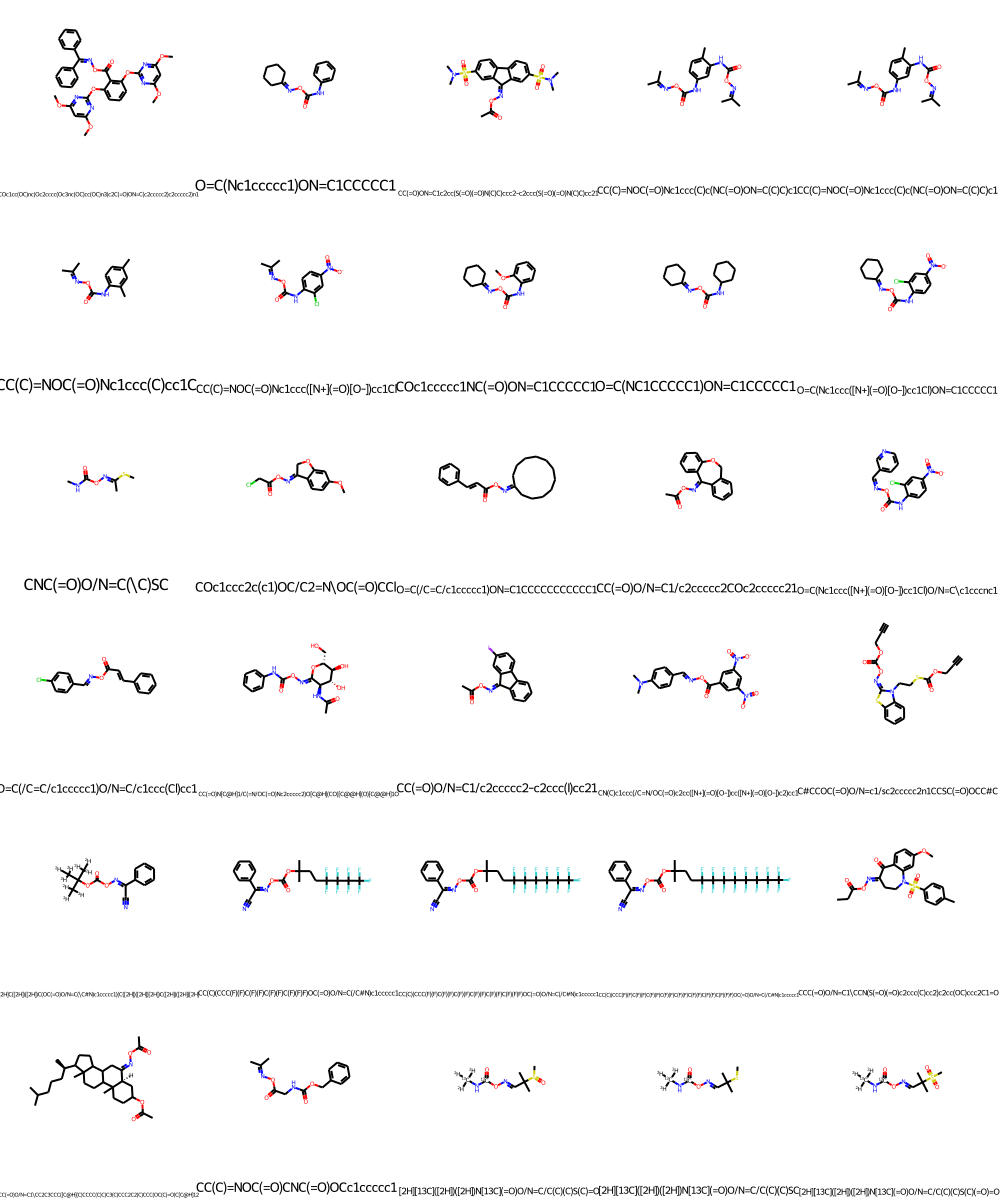

In [1]:
from smiles.grid_mol import grid_mols
grid_mols(objects=df['Smiles'].values.tolist(), row=5)